# A Bayesian Decision Theory Workflow: Port to Numpyro

In this notebook I explore the *Bayesian Decision Theory Workflow* described in the amazing blog post [A Bayesian Decision Theory Workflow](https://daniel-saunders-phil.github.io/imagination_machine/posts/a-bayesian-decision-theory-workflow/) by [Daniel Saunders](https://github.com/daniel-saunders-phil). It is a great resource to understand how to use Bayesian methods for optimization problems. In the original post, Daniel explains the theory and key concepts using [PyMC](https://www.pymc.io/) and its computational backend [PyTensor](https://pytensor.readthedocs.io/en/latest/). He does a remarkable job presenting powerful PyTensor features to manipulate and operate with symbolic computational graphs. I can only recommend you to read it!

As part of the learning exercise, I ported the workflow to [Numpyro](https://github.com/pyro-ppl/numpyro) and [JAX](https://github.com/google/jax). 

## Prepare Notebook


In [1]:
from functools import partial

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from jax import random
from jaxtyping import Array, Float, UInt
from numpyro.handlers import condition, do, seed, trace
from numpyro.infer import MCMC, NUTS
from numpyro.infer.util import Predictive

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=10)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

## Setting Up the Problem

In this example we are interested in maximizing the profit of a product as a function of its price.

\begin{align*}
    \text{profit} & = (\text{price} - \text{cost}) \times \text{sales}
    \\
    \text{sales} & = a \times \text{price}^b
\end{align*}

Here we assume a constant elasticity model for the sales as a function of the price. The elasticity is given by $b$.


Let's code up the profit function and show the profit vs price curve for a set of fixed parameters.


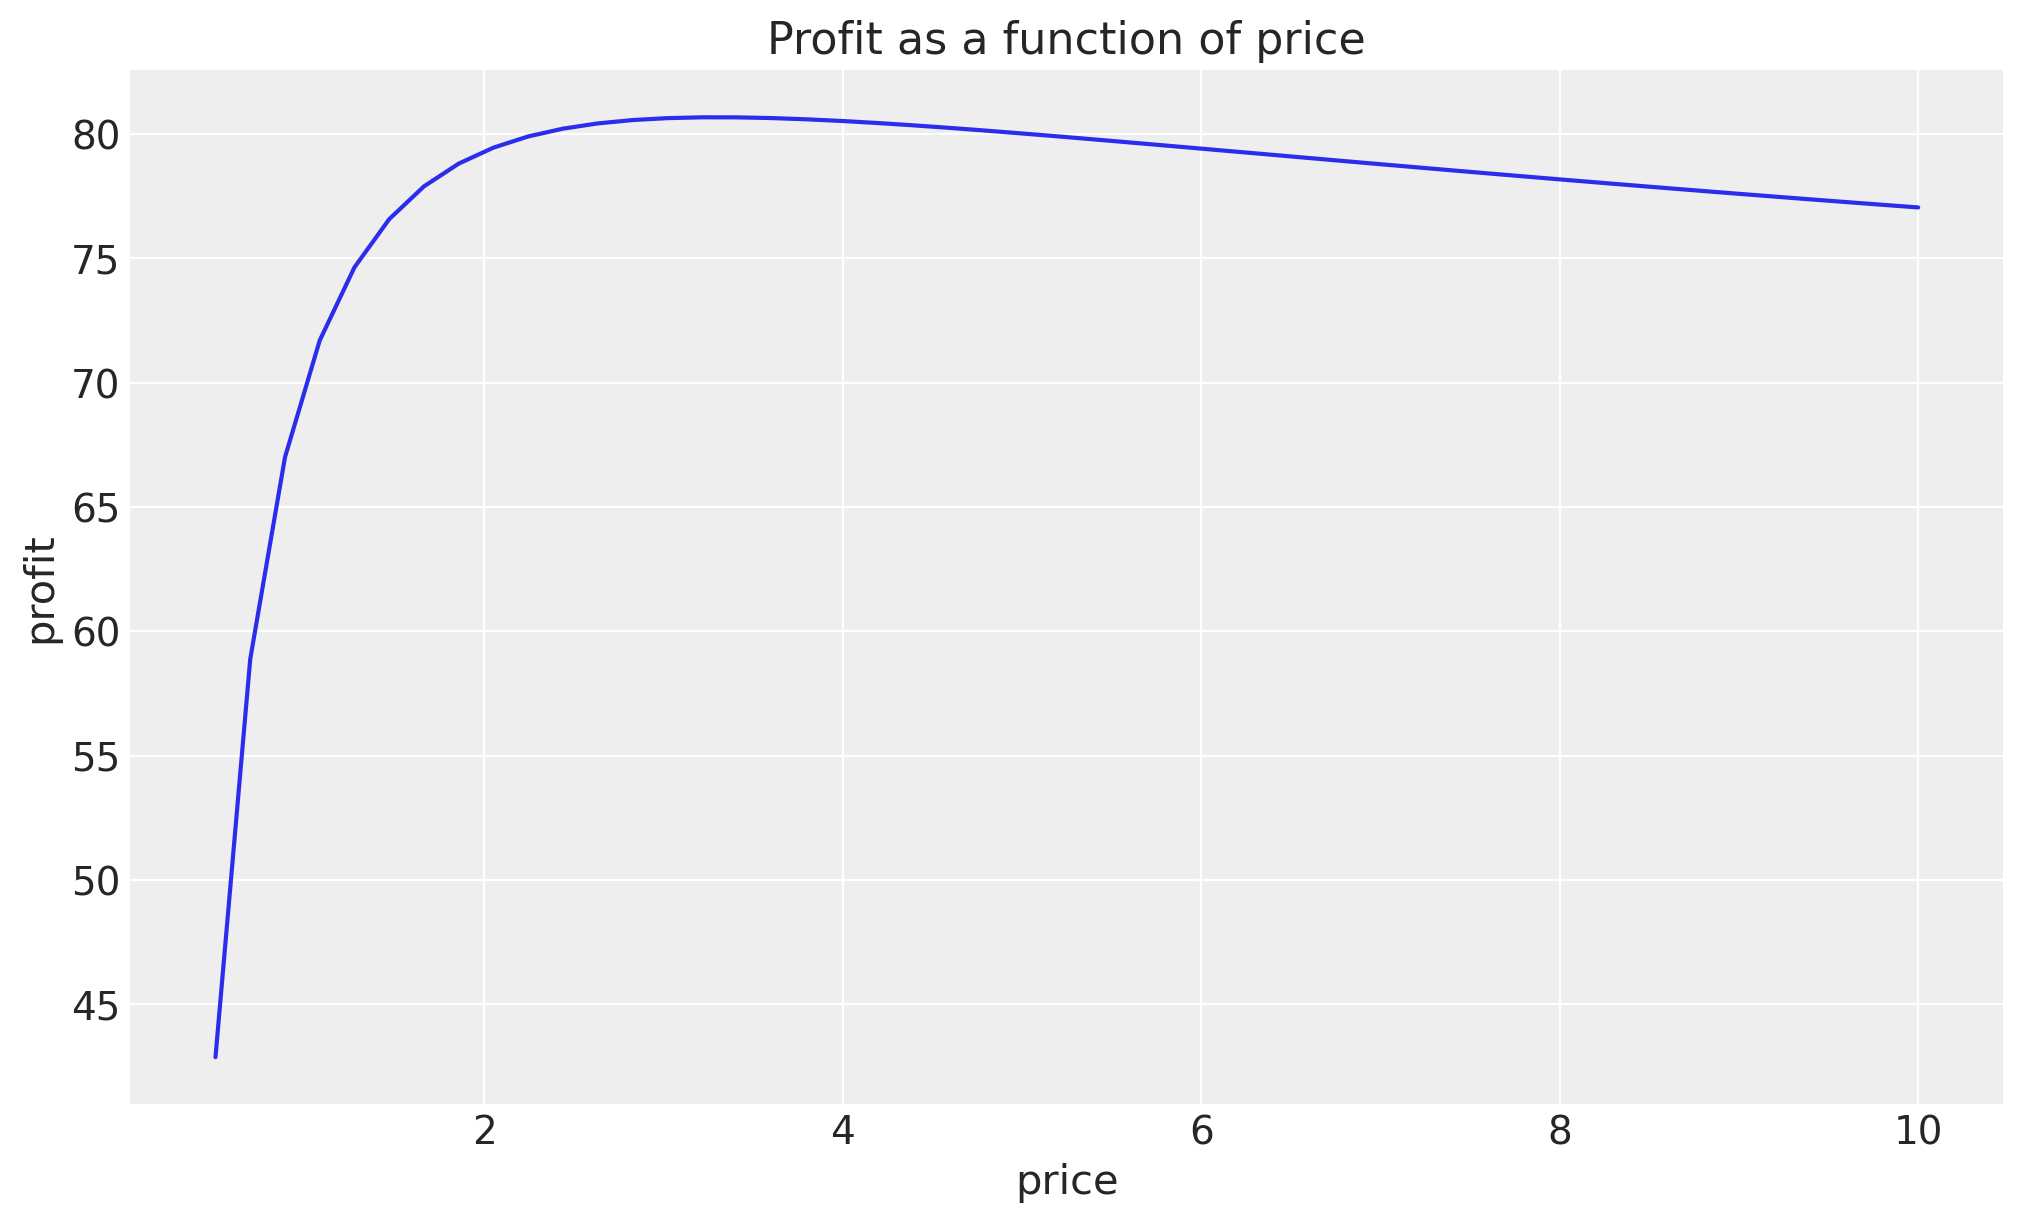

In [2]:
def unit_profit(price: Float[Array, " n"], cost: float = 0.3) -> Float[Array, " n"]:
    return price - cost


def profit(
    price: Float[Array, " n"], a: float, b: float, cost: float = 0.3
) -> Float[Array, " n"]:
    return unit_profit(price, cost) * a * price**b


price = jnp.linspace(start=0.5, stop=10, num=50)

a_true = 100.0
b_true = -1.1

fig, ax = plt.subplots()
ax.plot(price, profit(price, a=a_true, b=b_true, cost=0.3))
ax.set(title="Profit as a function of price", xlabel="price", ylabel="profit");

By eye-balling the plot, we can see that the maximum profit is achieved at a price of around $3.0$.

We can of course solve this analytically by taking the derivative of the profit function with respect to the price and setting it to zero.

\begin{align*}
    \frac{d\text{profit}}{d\text{price}} & = a \times \text{price}^b + a \times b \times \text{price}^{b-1} \times (\text{price} - \text{cost}) = 0
\end{align*}

Solving for the price that maximizes the profit, we get:

\begin{align*}
    \text{price}^* = \frac{b \times \text{cost}}{1 + b}
\end{align*}

Let's compute the optimal price for our true parameters.

In [3]:
price_optimal = (b_true * 0.3) / (1 + b_true)

price_optimal

3.299999999999997

This is reasonable given the plot above.

**Remark:** Note that the parameter $a$ doesn't appear in the optimal price formula. This makes sense because $a$ is just a scaling factor for sales, so it doesn't affect where the maximum occurs.

## Generate Synthetic Data

As we want to do inference and then optimization, we need to generate some synthetic data. We do this by simply sampling from a generative model:

In [4]:
def model(price: Float[Array, " n"]) -> Float[Array, " n"]:
    mu_a = 100.0
    sigma_a = 40.0
    concentration_a = (sigma_a / mu_a) ** 2
    rate_a = mu_a / sigma_a**2

    a = numpyro.sample("a", dist.Gamma(concentration=concentration_a, rate=rate_a))

    b = numpyro.sample("b", dist.Normal(loc=0, scale=1))

    sigma = numpyro.sample("sigma", dist.HalfNormal(scale=1))

    mu = numpyro.deterministic("mu", a * price**b)

    numpyro.sample("sales", dist.Normal(loc=mu, scale=sigma))

    return mu

Next, we simply get a sample for the sales by setting the true parameters in the model and sampling from it.

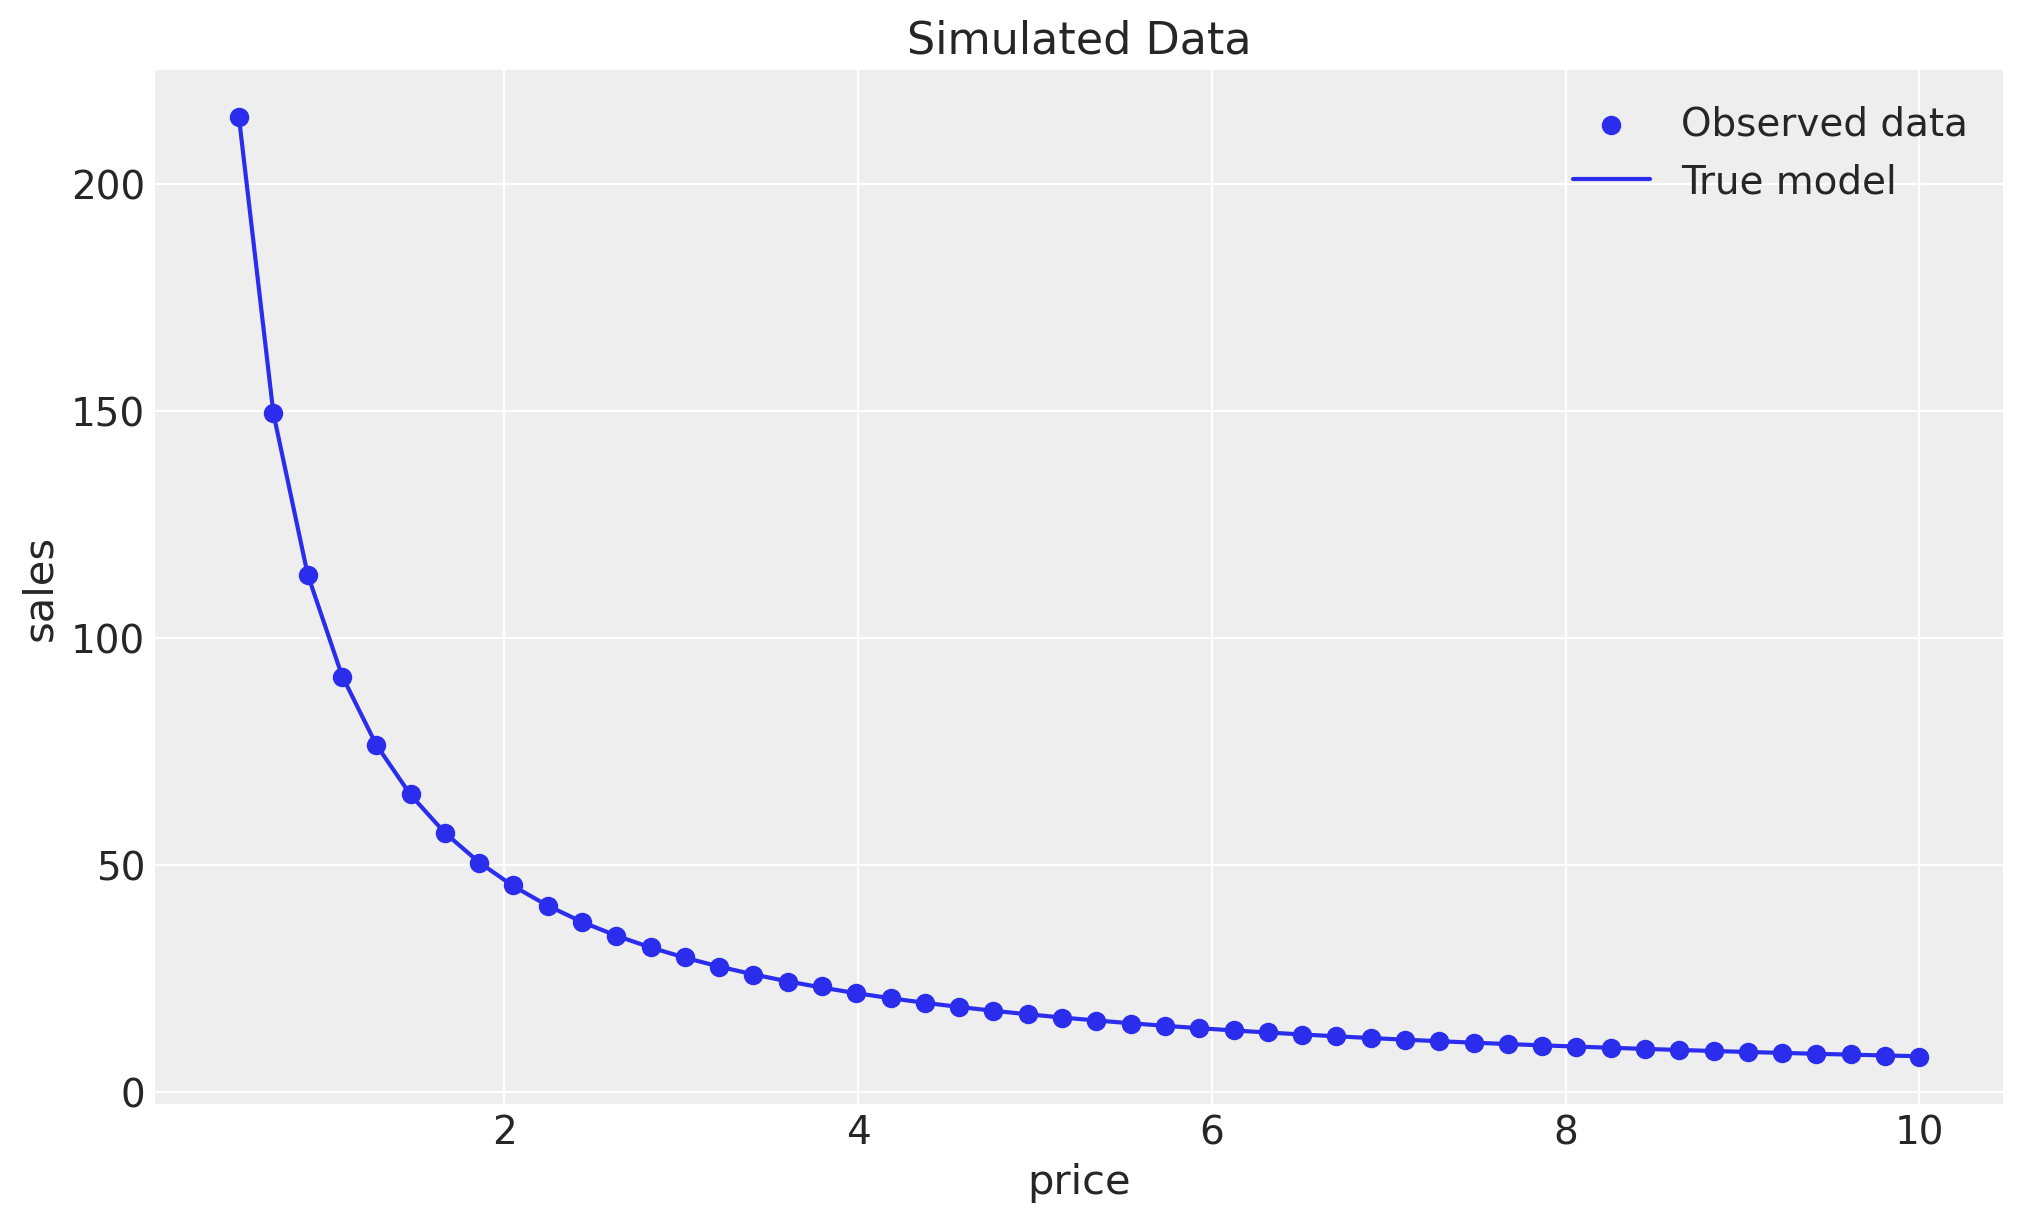

In [5]:
# Generate synthetic data
true_data = {"a": a_true, "b": b_true}
rng_key, rng_subkey = random.split(rng_key)
samples = trace(seed(do(model, true_data), rng_subkey)).get_trace(price)
sales_obs = samples["sales"]["value"]

# Plot the synthetic sales as a function of the price
fig, ax = plt.subplots()
ax.scatter(price, sales_obs, label="Observed data")
ax.plot(price, a_true * price**b_true, label="True model")
ax.legend()
ax.set(title="Simulated Data", xlabel="price", ylabel="sales");

We do see that the sales-price relationship is close to the true model, but of course we see the effect of the noise in the data.

## Inference

Now we can use the observed data to infer the parameters of the model. We do this by conditioning the model on the observed data and then sampling from the posterior distribution.


In [6]:
conditioned_model = condition(model, {"sales": sales_obs})

nuts_kernel = NUTS(conditioned_model)
mcmc = MCMC(nuts_kernel, num_warmup=1_000, num_samples=1_000, num_chains=4)
rng_key, rng_subkey = random.split(rng_key)
mcmc.run(rng_subkey, price)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

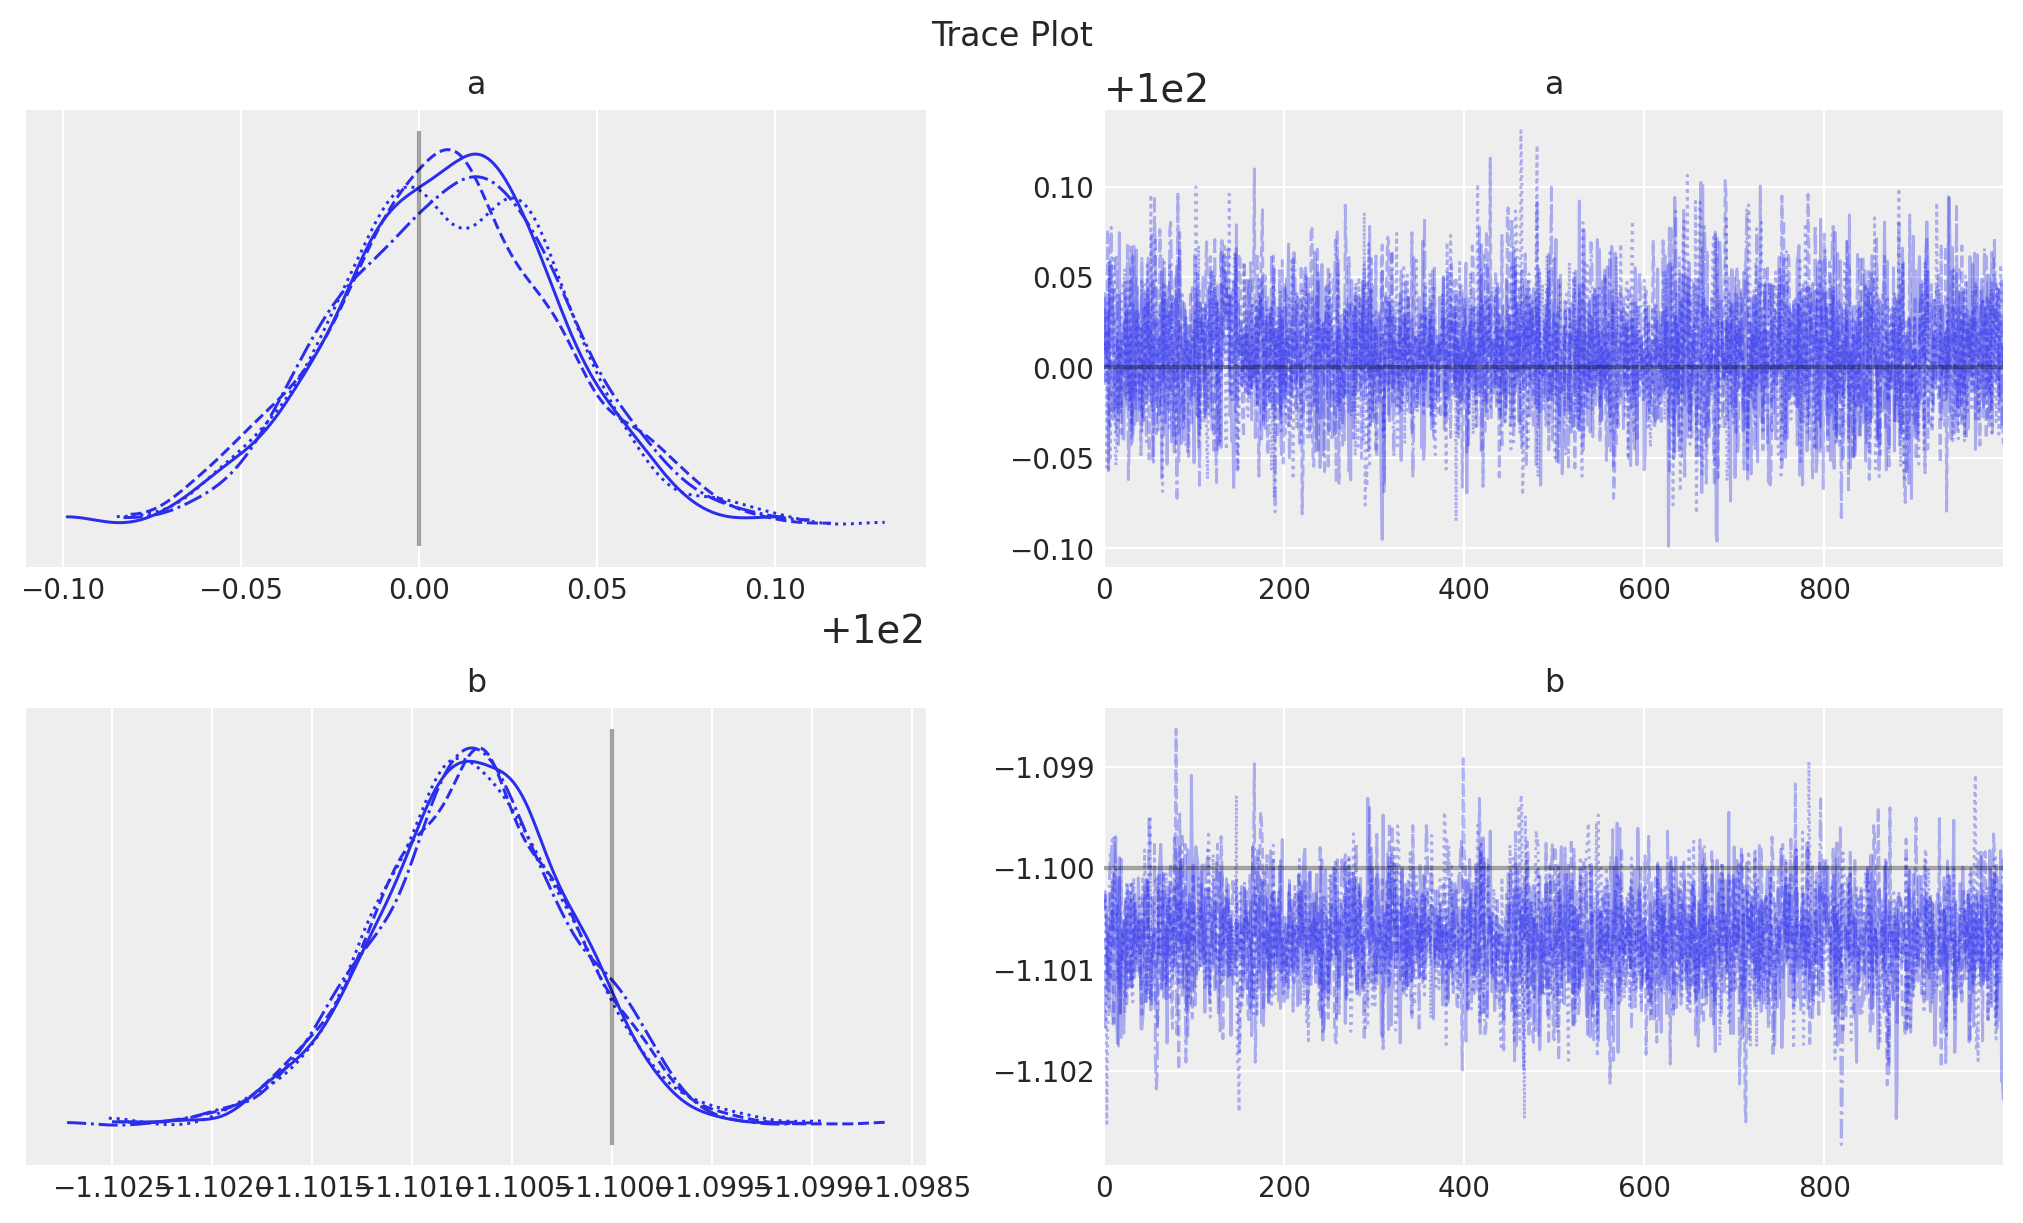

In [7]:
idata = az.from_numpyro(
    mcmc,
    coords={"idx": range(len(price))},
    dims={"mu": ["idx"], "sales": ["idx"]},
)

axes = az.plot_trace(
    data=idata,
    var_names=["a", "b"],
    compact=True,
    lines=[("a", {}, a_true), ("b", {}, b_true)],
    backend_kwargs={"figsize": (10, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Trace Plot");

The inferred parameters are close to the true parameters.

## Utility Function

Now we need to use these posterior samples to compute the utility function (in this case the profit) as a function of the price. To do this in NumPyro, we can use the [`Predictive`](https://num.pyro.ai/en/stable/utilities.html#numpyro.infer.util.Predictive) utility function.

In [8]:
# We are interested in the expected sales, i.e. the variable mu.
predictive = Predictive(model, mcmc.get_samples(), return_sites=["mu"])


# We want to compute the expected sales as a function of the price.
def predictive_mean(
    rng_key: UInt[Array, "2"], price: Float[Array, " 1"]
) -> Float[Array, ""]:
    return jnp.mean(predictive(rng_key, price)["mu"])


# We now seed and JIT the function.
rng_key, rng_subkey = random.split(rng_key)
predictive_mean_jit = jax.jit(partial(predictive_mean, rng_subkey))

We can now compute the utility function explicitly:

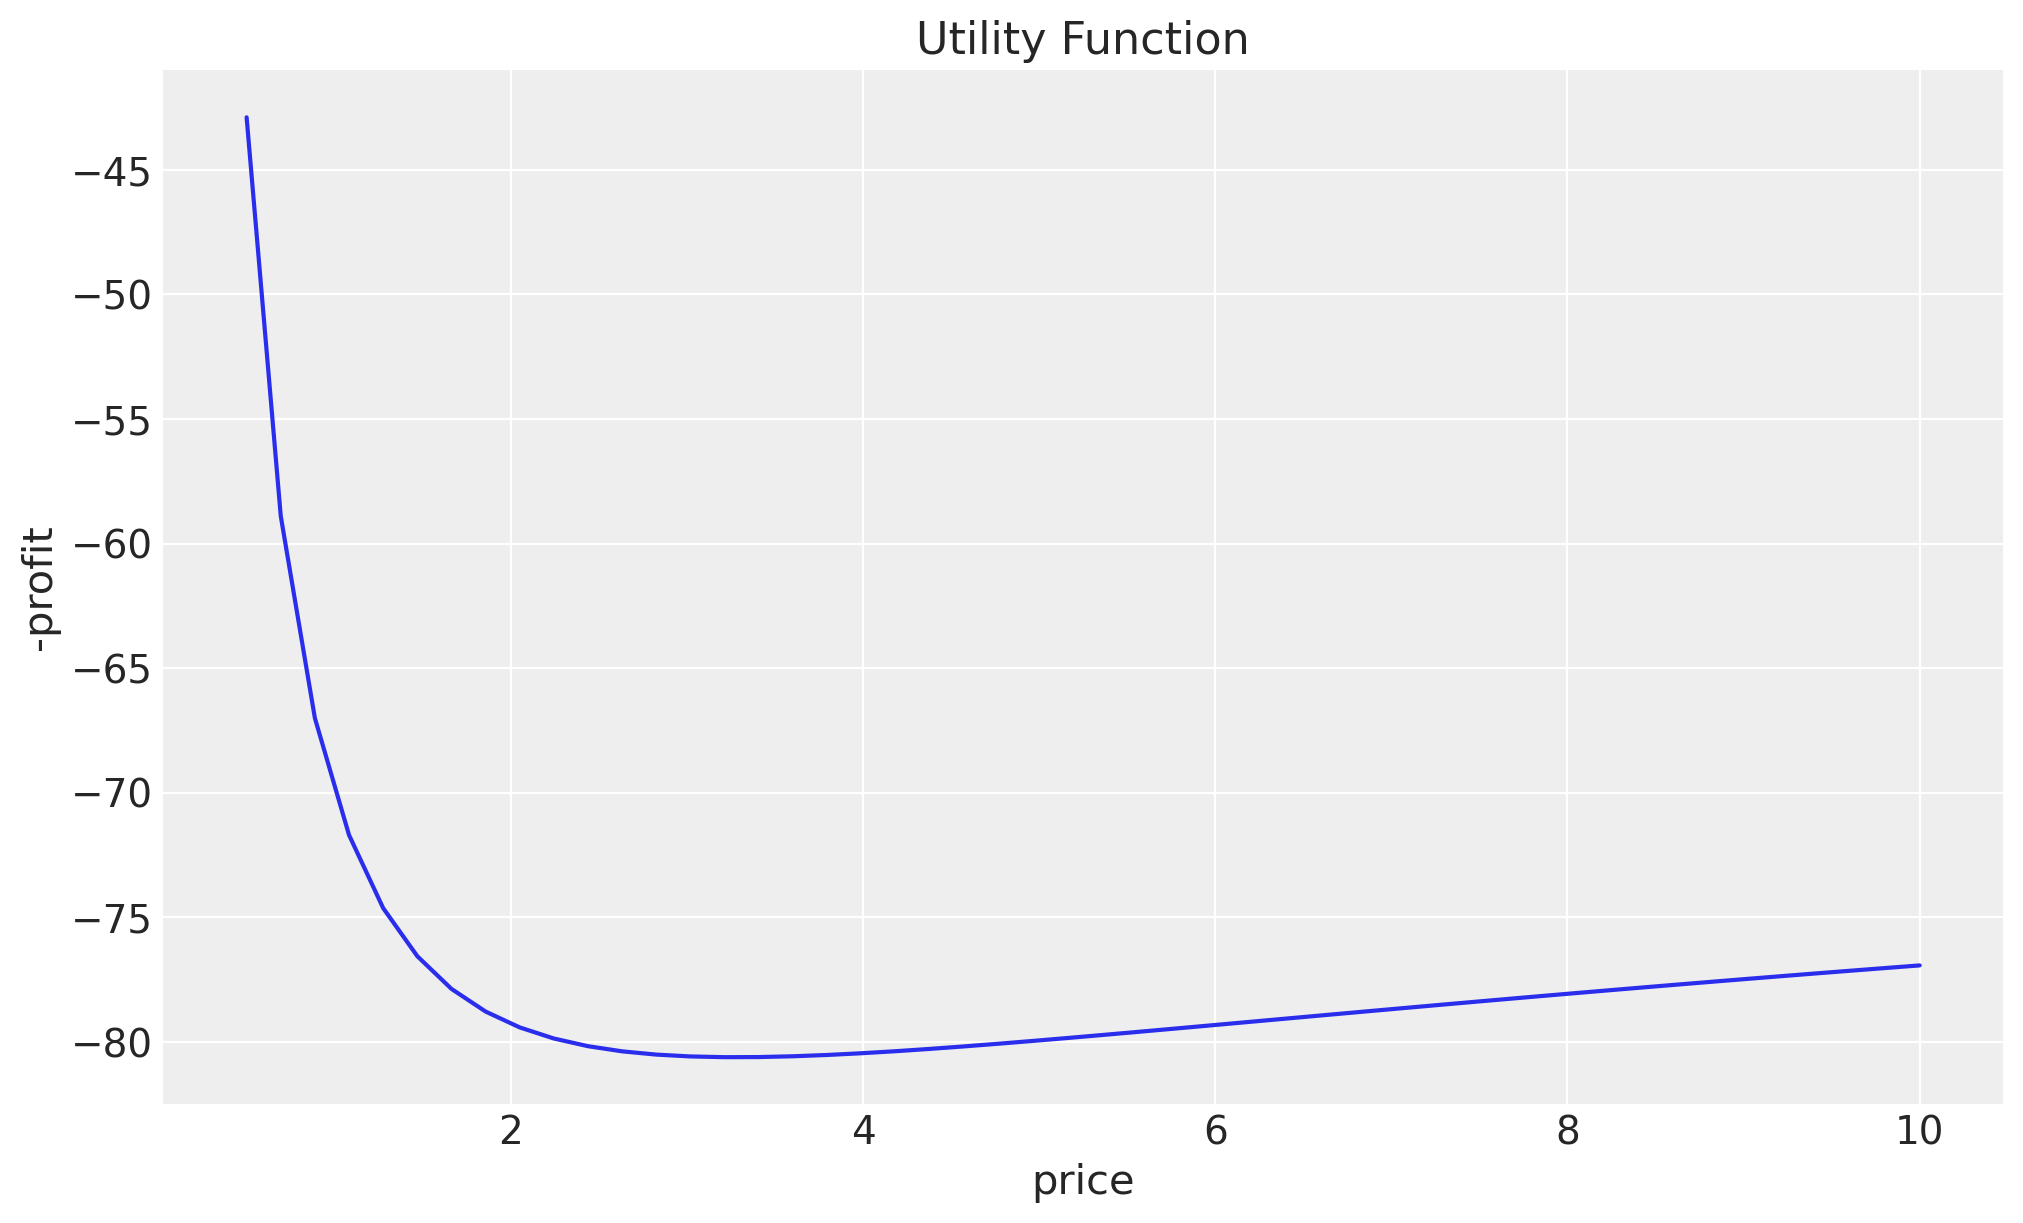

In [9]:
def objective(price: Float[Array, " 1"], cost: float = 0.3) -> Float[Array, ""]:
    unit_profit = price - cost
    mu = predictive_mean_jit(price)
    # We need to return a scalar.
    # We add a minus sign as we will be using a minimizer.
    return (-1 * unit_profit * mu).reshape(())


# Let's plot the utility function.
fig, ax = plt.subplots()
ax.plot(price, jax.vmap(objective)(price.reshape(-1, 1)))
ax.set(title="Utility Function", xlabel="price", ylabel="-profit");

As expected from the analytical solution, the maximum profit is achieved at a price of around $3.0$. We want to use this utility function to find the precise optimal price.

## Optimization

We can use [`jax.scipy.optimize.minimize`](https://jax.readthedocs.io/en/latest/jax.scipy.html#jax.scipy.optimize.minimize) to find the maximum of the utility function.

In [10]:
result = jax.scipy.optimize.minimize(objective, x0=jnp.array([1.0]), method="BFGS")

result.x

Array([3.2792895], dtype=float32)

The optimal price is very close to our analytical solution! 

Finally, we can plot the utility function and the optimal price.

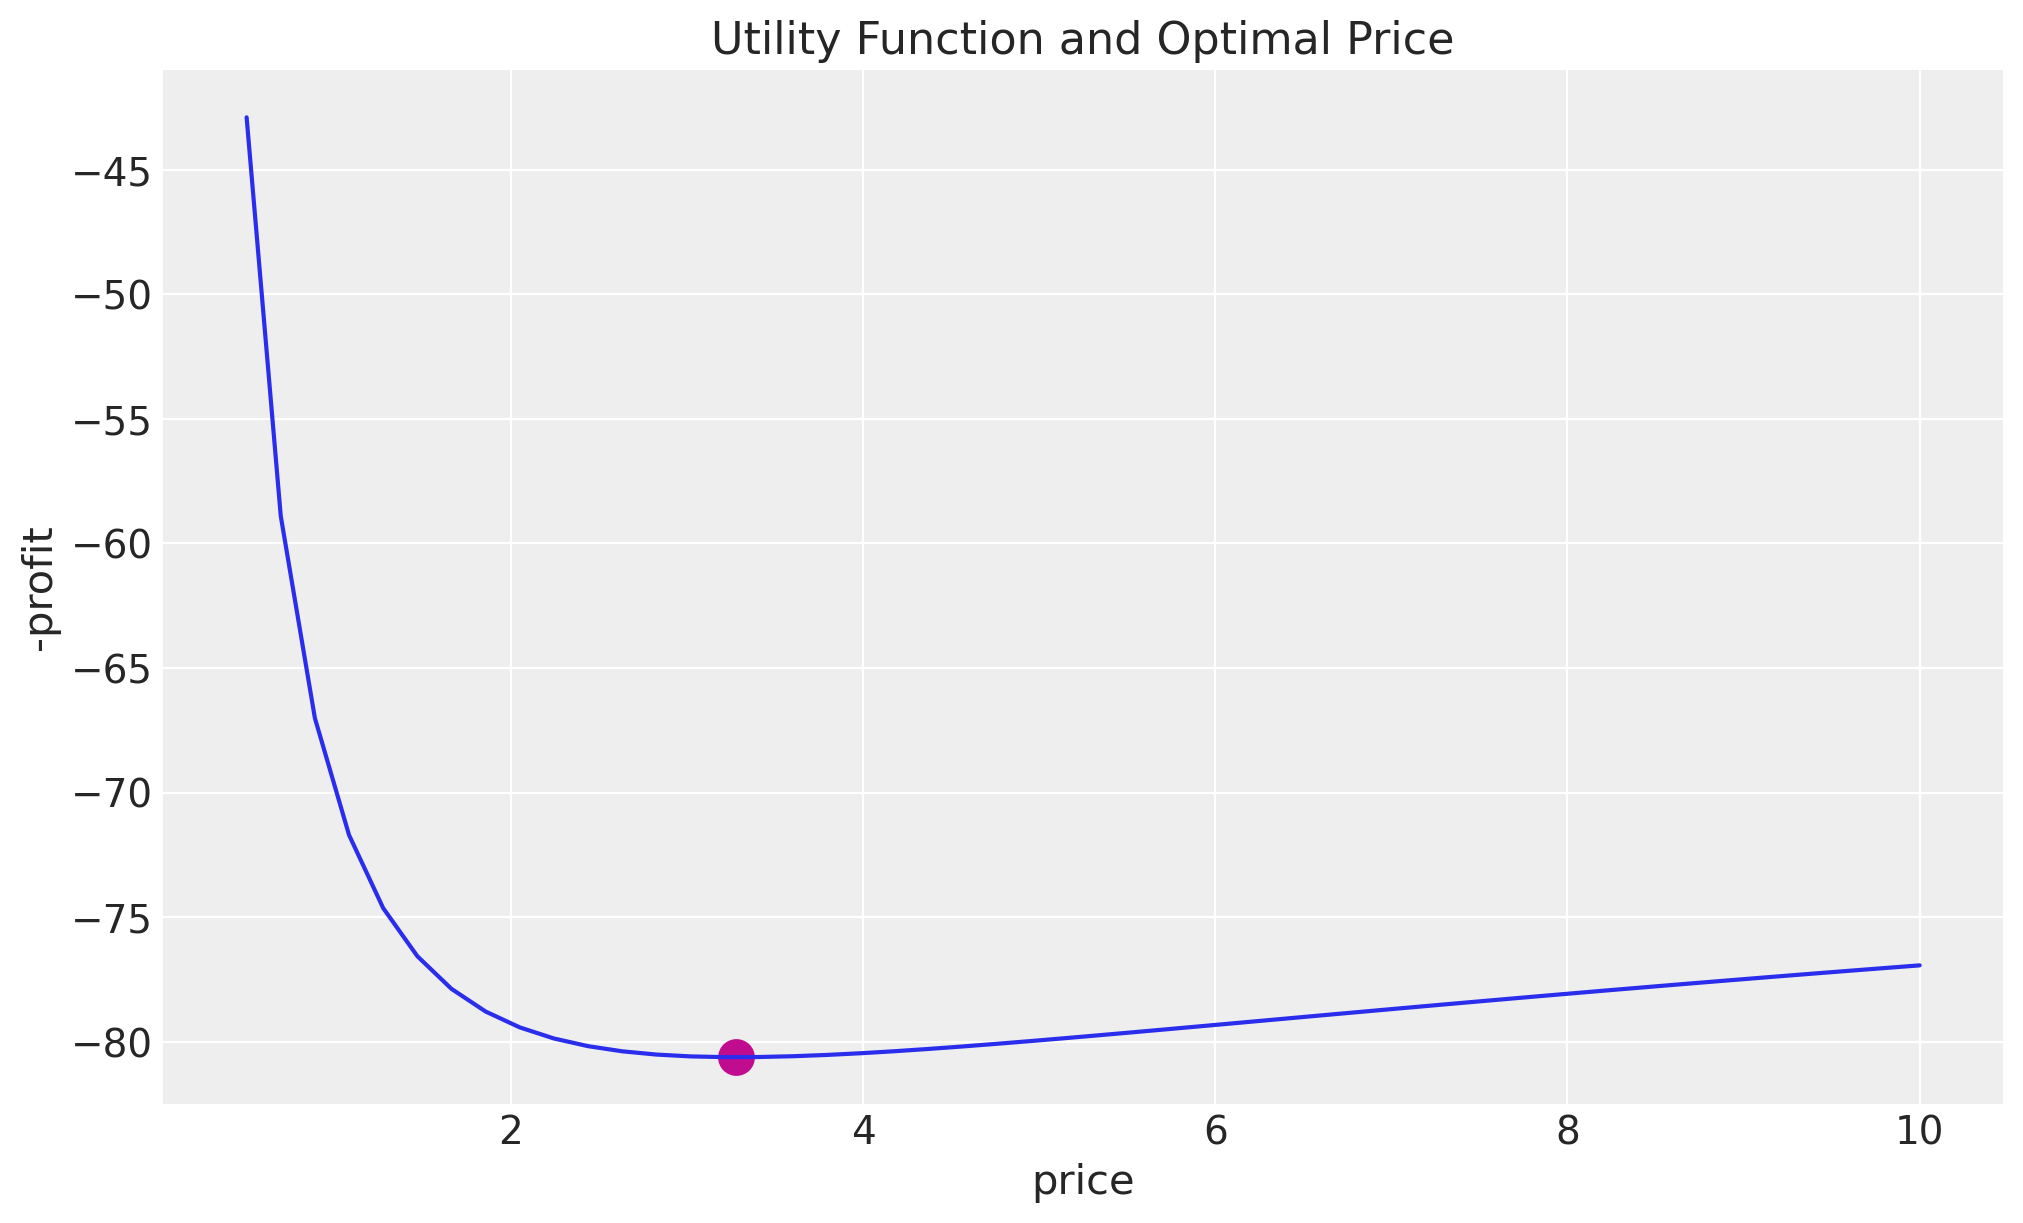

In [11]:
fig, ax = plt.subplots()
ax.plot(price, jax.vmap(objective)(price.reshape(-1, 1)))
ax.scatter(result.x, objective(result.x), color="C3", s=150)
ax.set(title="Utility Function and Optimal Price", xlabel="price", ylabel="-profit");